# Visualización de conjuntos de datos de Stanford y Santa Maria
Roberto Araya Day

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import resource
import tensorflow_datasets as tfds
import random
import pandas as pd
from tqdm import trange
import csv
import os
from pathlib import Path
import nrrd
import pydicom
from PIL import Image
from sklearn.metrics import roc_auc_score, recall_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from simple import SimpleModel, BinaryCNN, SimpleModel2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

/home/roberto/anaconda3/envs/lung_radiomics/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

## Visualizar imágenes

In [3]:
def show_slice_window(slice, level, window):

    """
    Permite ajustar nivel y ancho de ventana para mejorar contraste de la imagen.
    input: imagen np.array 2D.
    output: imagen np.array 2D ajustada.
   """
    max = level + window/2
    min = level - window/2
    return slice.clip(min,max)

def visualizeImgMask(img, mask, cmap_clr='gray'):
    """
    Función para visualizar las imágenes, máscaras y fusión.
    INPUT: imágenes y máscaras como numpy array 3D (numero de imagenes, alto, ancho),
    PET: True or False. Si es True se visualiza en inverso (cmap=gray_r),
    solo por un tema de convención de la visualización del PET.
    """
    img, mask = img.numpy(), mask.numpy()
    img, mask = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8), (mask * 255).astype(np.uint8) # adjust scale
    img_pil, mask_pil = Image.fromarray(img), Image.fromarray(mask)

    f, axarr = plt.subplots(1, 3, figsize=(10, 10))
    axarr[0].set_title("Exam Image")
    axarr[0].imshow(img_pil, cmap=cmap_clr)
    axarr[1].set_title("Mask")
    axarr[1].imshow(mask_pil, cmap='Blues')
    axarr[2].set_title("Fusion")
    axarr[2].imshow(img_pil, cmap='gray')
    axarr[2].imshow(mask_pil, cmap='gnuplot', alpha=0.6)
    plt.show()

def roiExtractionResize(img_exam, mask_exam, img_size, margin=3):
    img_instance, mask_instance = img_exam.numpy(), mask_exam.numpy()
    index = np.where(mask_instance)

    # define coordinates
    x2 = np.unique(index[0])[-1]
    x1 = np.unique(index[0])[0]

    y2 = np.unique(index[1])[-1]
    y1 = np.unique(index[1])[0]

    # width and height
    width = x2 - x1
    height = y2 -y1

    if width > height:
        lmargin = (width-height)//2
        rmargin = width-lmargin
        x1 = x1 - lmargin
        x2 = x2 + rmargin

    else:
        tmargin = (height - width) // 2
        bmargin = height - tmargin
        y1 = y1 - tmargin
        y2 = y2 + bmargin
    
    roi = img_instance[x1-margin:x2+margin, y1-margin:y2+margin]
    
    # Convert NumPy array to Pillow Image
    roi_image = Image.fromarray(roi)

    # Resize the image to (img_size, img_size)
    roi_resized = roi_image.resize((img_size, img_size))

    # Convert back to NumPy array
    roi_resized_array = np.array(roi_resized)

    return roi_resized_array


def roiExtractionSize(img, mask, total_size=None, margin=3):
    """
    Function to extract ROIs from images while ensuring a consistent total size for all ROIs.

    INPUT:
    img: Numpy array of images.
    mask: Numpy array of masks.
    total_size: The desired total size (width and height) of the extracted ROIs.

    OUTPUT: Numpy array containing the ROIs.
    """
    
    img_instance, mask_instance = img.numpy(), mask.numpy()
    index = np.where(mask_instance)

    if total_size == None:
        roi = img_instance[np.unique(index[0])[0]-margin:np.unique(index[0])[-1]+margin, np.unique(index[1])[0]-margin: np.unique(index[1])[-1]+margin]
    else:
    
        # Calculate the center of the mask.
        center_row, center_col = int(np.mean(index[0])), int(np.mean(index[1]))
    
        # Calculate the size of the ROI based on the total size.
        half_size = total_size // 2
    
        # Determine ROI boundaries with the margin.
        min_row = max(0, center_row - half_size)
        max_row = min(mask_instance.shape[0], center_row + half_size)
        min_col = max(0, center_col - half_size)
        max_col = min(mask_instance.shape[1], center_col + half_size)
    
        # Calculate the width and height of the ROI.
        roi_height = max_row - min_row
        roi_width = max_col - min_col
    
        # Case 1: If the ROI is smaller than the total_size, add a margin to make it total_size.
        if roi_height < total_size:
            margin = (total_size - roi_height) // 2
            min_row -= margin
            max_row += margin
    
        if roi_width < total_size:
            margin = (total_size - roi_width) // 2
            min_col -= margin
            max_col += margin
    
        # Case 2: If the ROI is larger than total_size, resize it.
        if roi_height > total_size or roi_width > total_size:
            scale_factor = total_size / max(roi_height, roi_width)
            new_height = int(roi_height * scale_factor)
            new_width = int(roi_width * scale_factor)
            min_row = max(center_row - new_height // 2, 0)
            max_row = min(min_row + new_height, mask_instance.shape[0])
            min_col = max(center_col - new_width // 2, 0)
            max_col = min(min_col + new_width, mask_instance.shape[1])
    
        # Extract the ROI with the desired size.
        roi = img_instance[min_row:max_row, min_col:max_col]
    
    return roi


## Visualizar ejemplos multimodales

In [6]:
def visualize_n_samples(n, body_ds, body_info, torax_ds, torax_info, pet_ds, pet_info):
    body_keys, torax_keys, pet_keys = list(body_info.splits.keys()), list(torax_info.splits.keys()), list(pet_info.splits.keys())

    for key in set(body_keys) & set(torax_keys) & set(pet_keys):
        body_data, torax_data, pet_data = body_ds[key], torax_ds[key], pet_ds[key]
        print("patient:", key)

        samples_counter = 0
        for body_sample, torax_sample, pet_sample in zip(body_data, torax_data, pet_data):
            print(body_sample['img_exam'].shape, torax_sample['img_exam'].shape, pet_sample['img_exam'].shape)
            print(body_sample['img_exam'].dtype, torax_sample['img_exam'].dtype, pet_sample['img_exam'].dtype)

            f, axarr = plt.subplots(2, 3, figsize=(n, n))
            
            for ax, sample, title in zip(axarr[0], [body_sample, torax_sample, pet_sample], ["Body Exam", "Torax 3D Exam", "Pet Exam"]):
                ax.set_title(title)
                if sample is pet_sample:
                    ax.imshow(sample['img_exam'], cmap='gray_r')
                else:
                    ax.imshow(sample['img_exam'], cmap='gray')
                ax.imshow(sample['mask_exam'], cmap='gnuplot', alpha=0.4)
                
            for ax, sample, title in zip(axarr[1], [body_sample, torax_sample, pet_sample], ["Body Exam", "Torax 3D Exam", "Pet Exam"]):
                ax.set_title(f"{title} ROI Mask")
                roi_img = roiExtractionSize(sample['img_exam'], sample['mask_exam'], 32, margin=8)
                #roi_img = enhance_contrast(roi_img)
                print(roi_img.shape)
                if sample is pet_sample:
                    ax.imshow(roi_img, cmap='gray')
                else:
                    roi_img = show_slice_window(roi_img, 60, 120)
                    ax.imshow(roi_img, cmap='gray')          
            plt.show()

            samples_counter += 1
            if samples_counter == n:
                break


patient: sm_007
(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


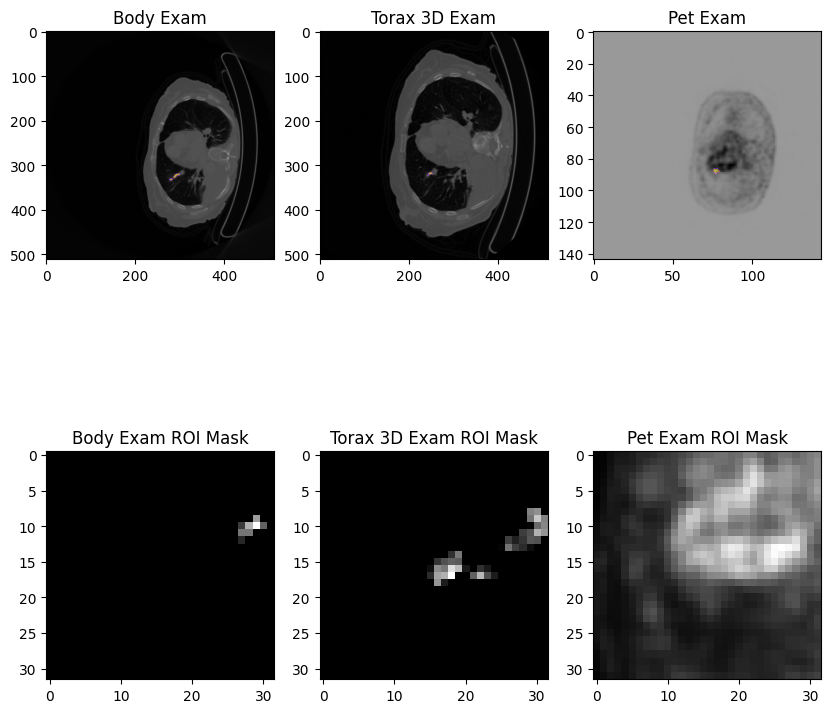

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


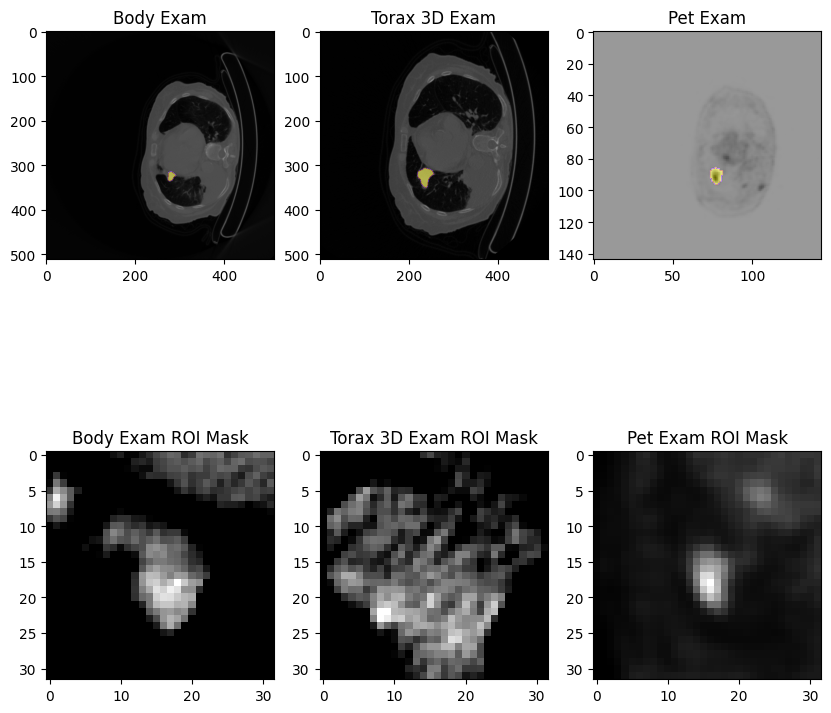

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


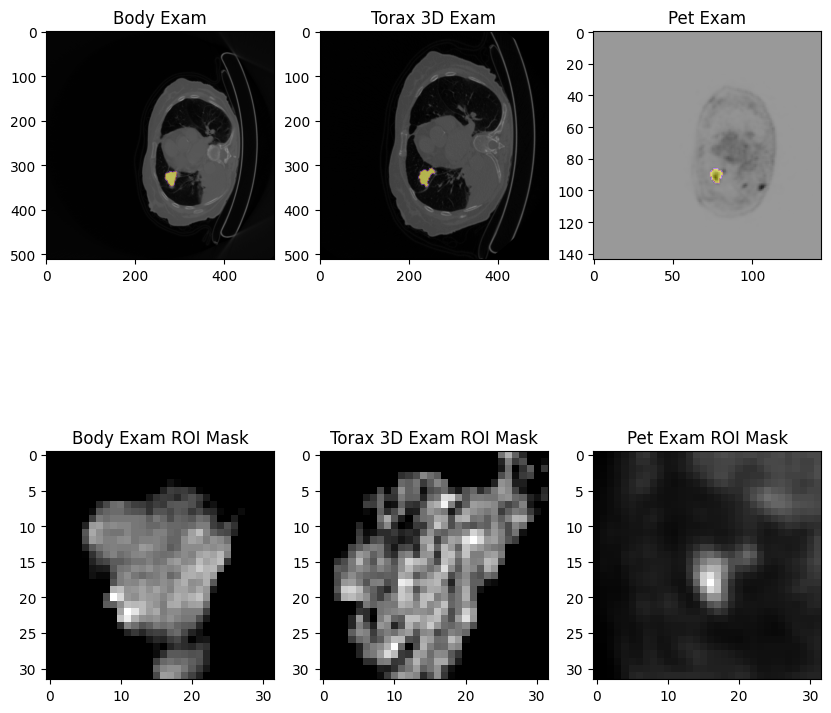

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


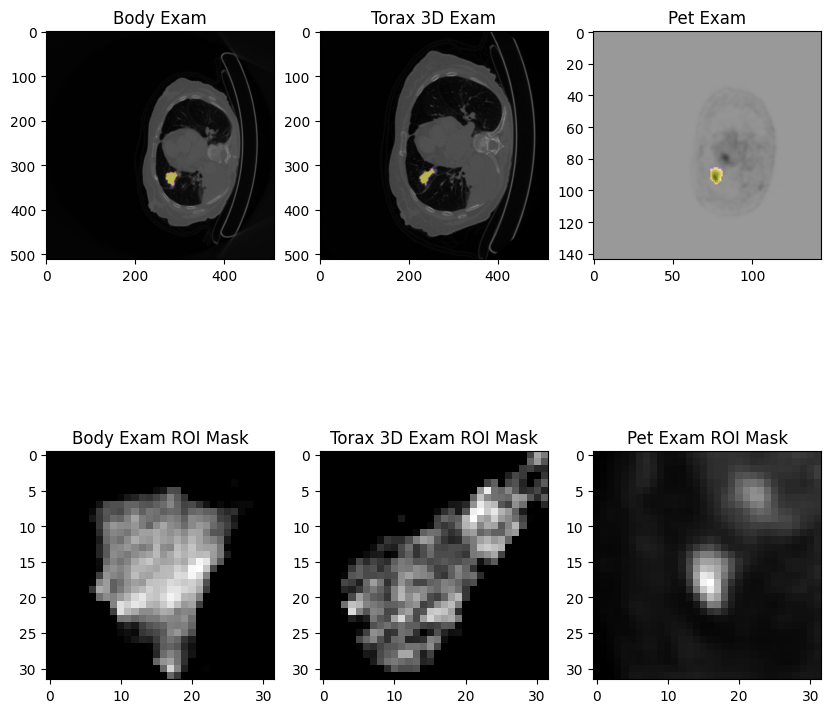

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


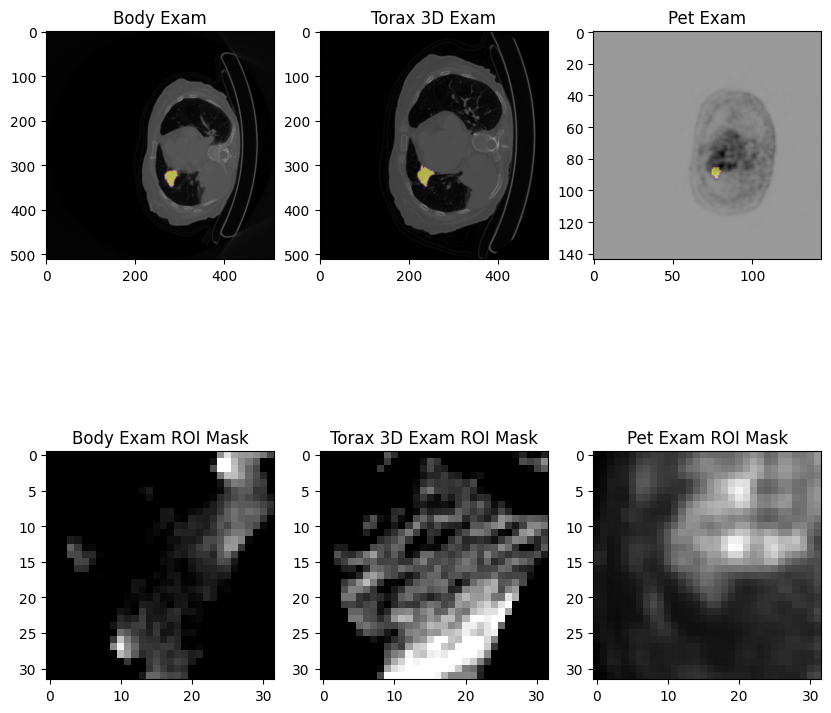

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


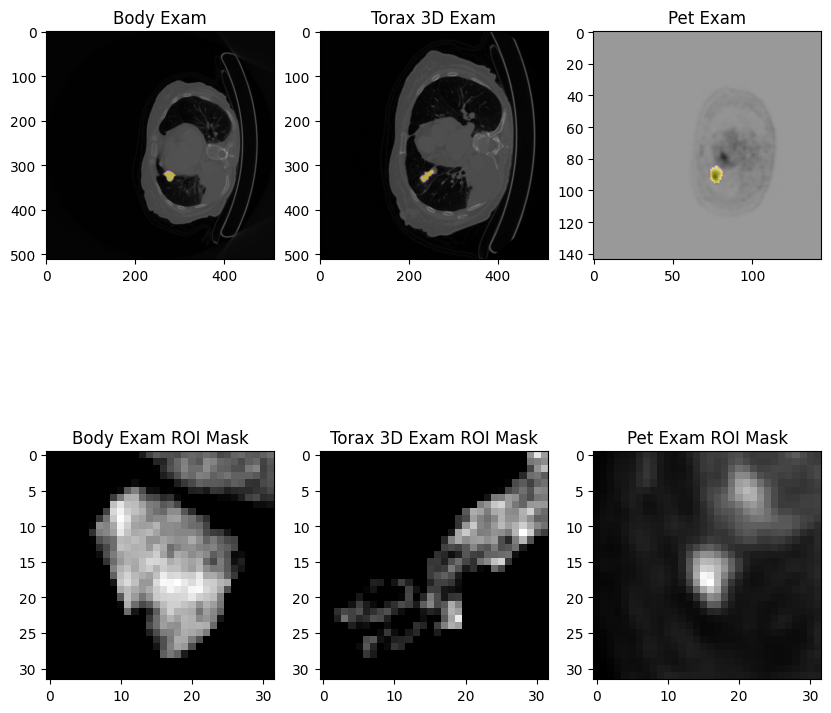

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


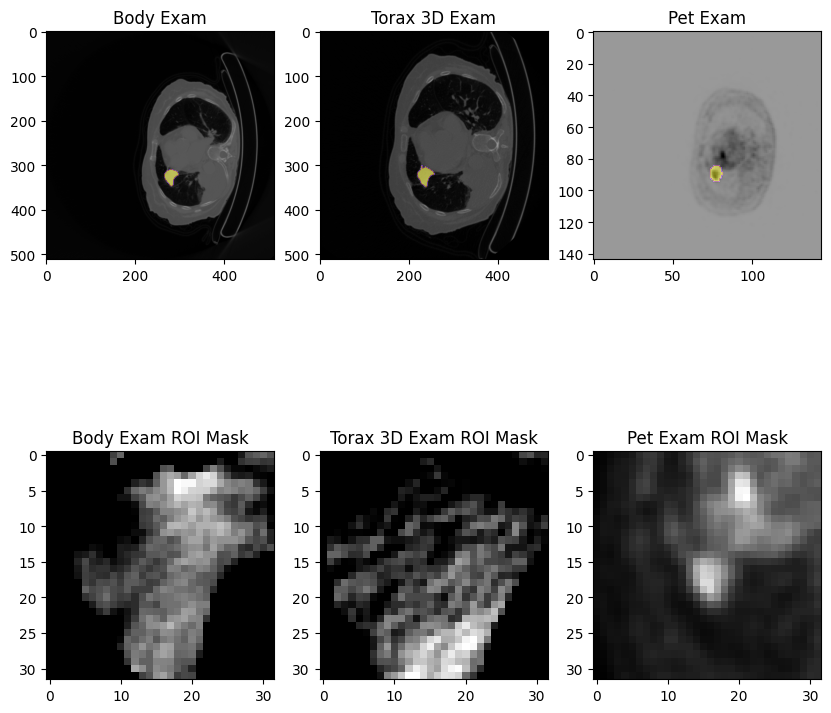

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


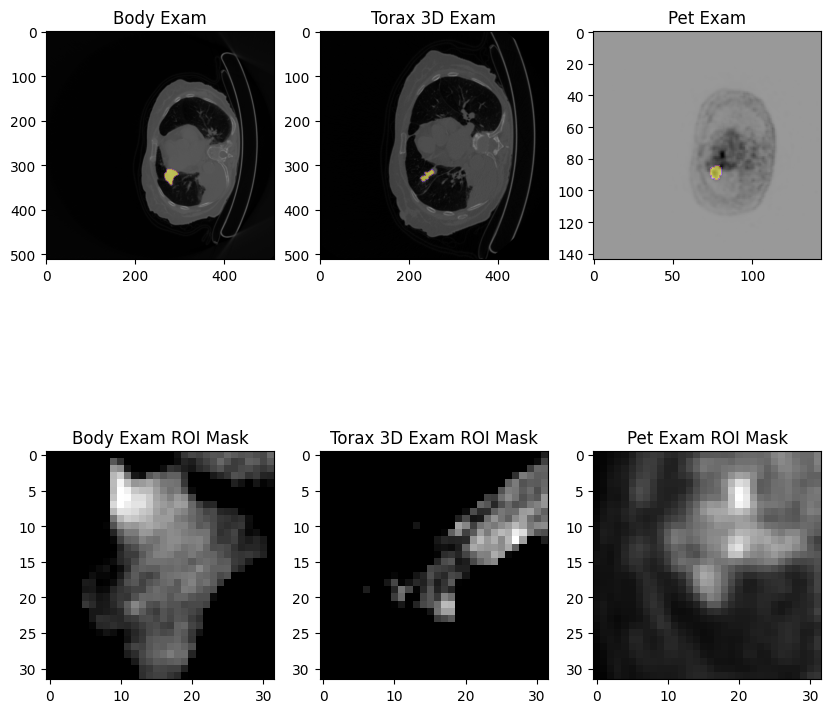

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


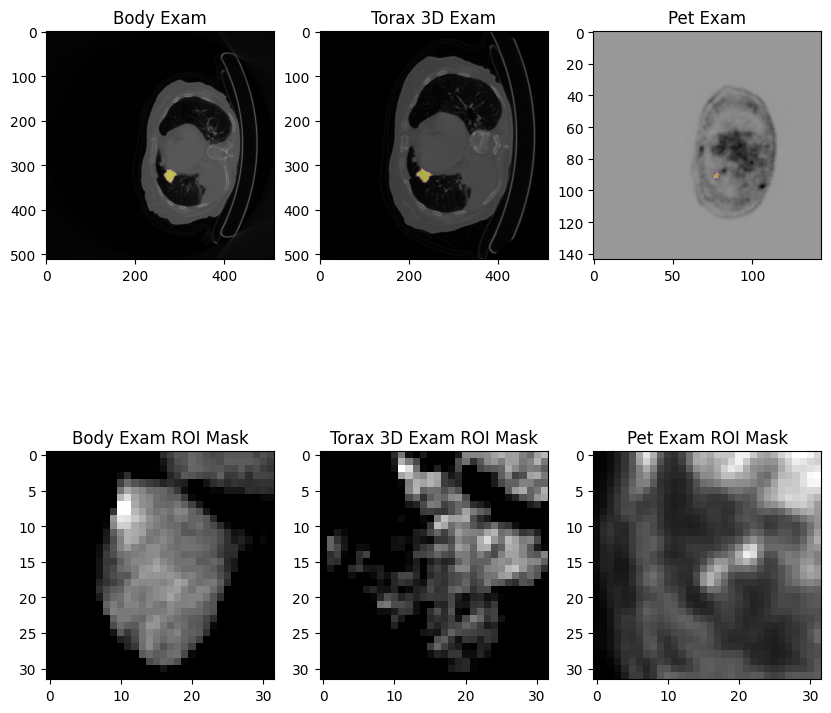

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


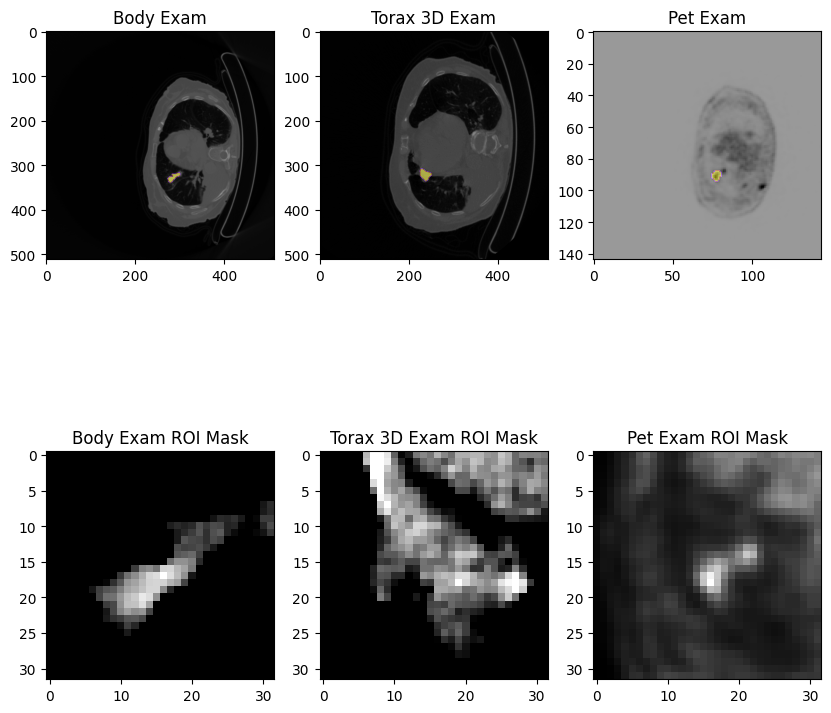

patient: sm_013
(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


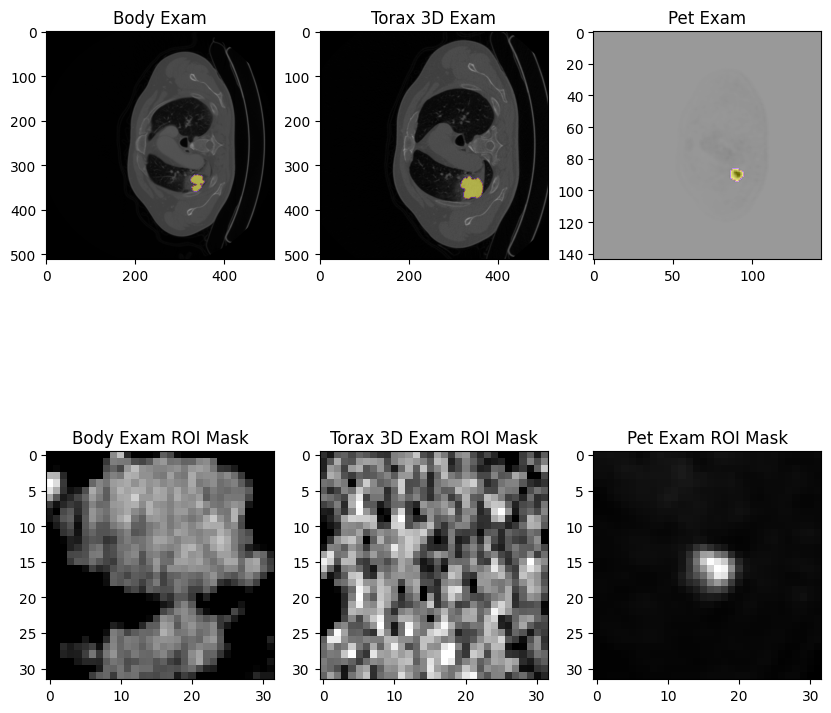

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


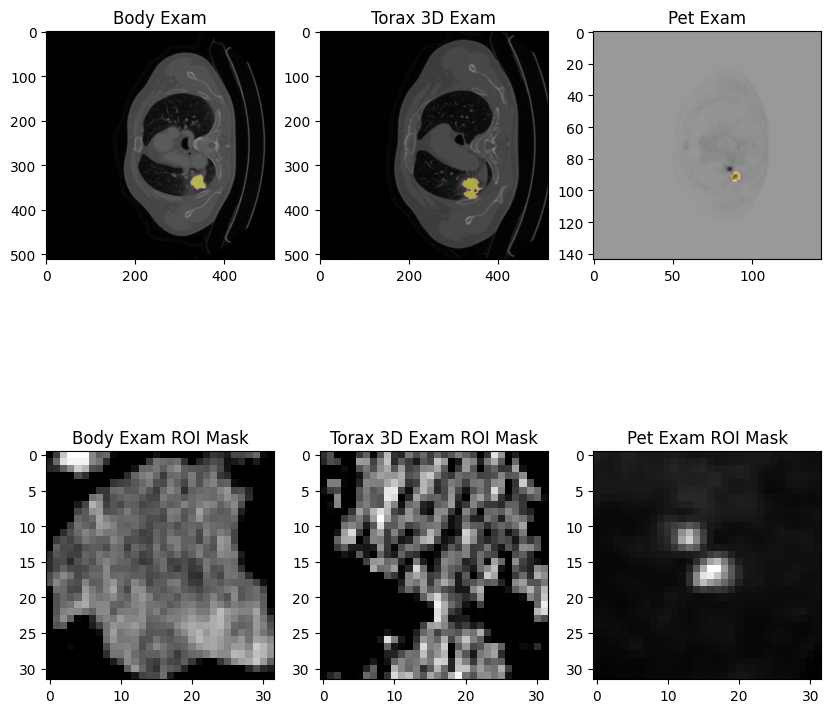

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


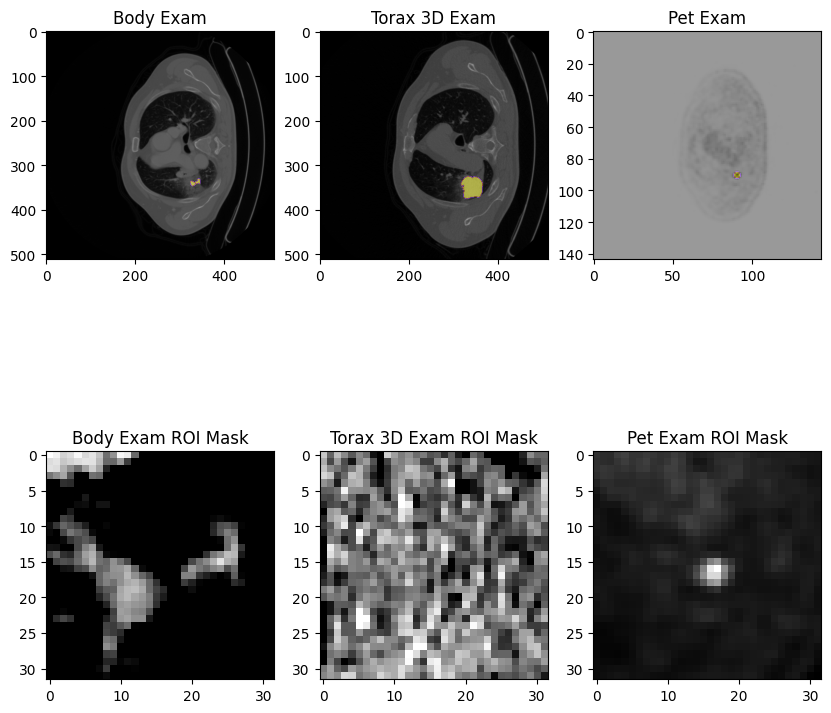

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


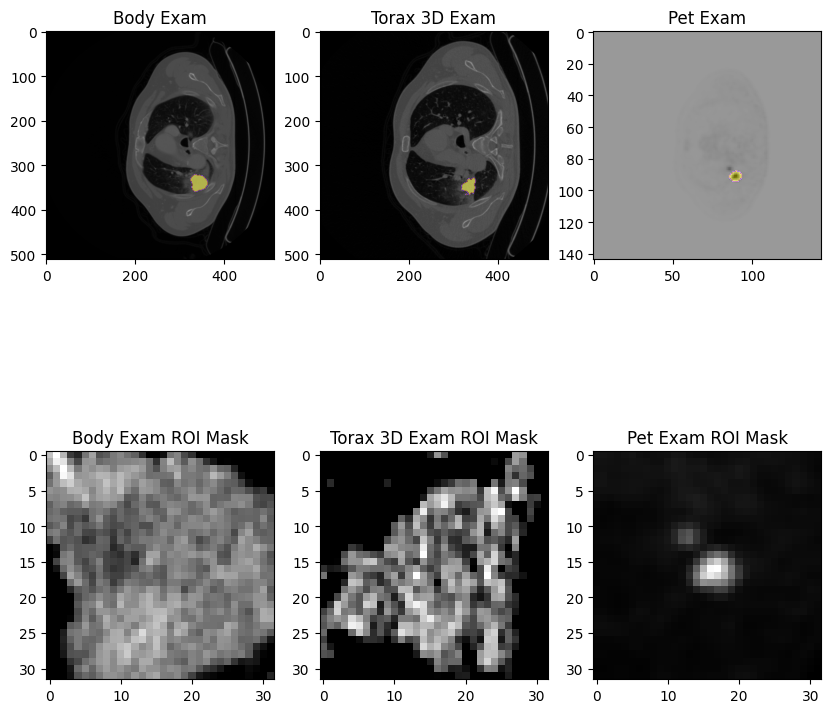

(512, 512) (512, 512) (144, 144)
<dtype: 'float32'> <dtype: 'float32'> <dtype: 'float32'>
(32, 32)
(32, 32)
(32, 32)


In [ ]:
santamaria_body_dataset, santamaria_body_info = tfds.load('santa_maria_dataset/body', with_info=True)
santamaria_torax_dataset, santamaria_torax_info = tfds.load('santa_maria_dataset/torax3d', with_info=True)
santamaria_pet_dataset, santamaria_pet_info = tfds.load('santa_maria_dataset/pet', with_info=True)

visualize_n_samples(10, santamaria_body_dataset, santamaria_body_info, santamaria_torax_dataset, 
                     santamaria_torax_info, santamaria_pet_dataset, santamaria_pet_info)

In [ ]:
stanford_body_dataset, stanford_body_info = tfds.load('stanford_dataset/ct', with_info=True)
stanford_torax_dataset, stanford_torax_info = tfds.load('stanford_dataset/chest_ct', with_info=True)
stanford_pet_dataset, stanford_pet_info = tfds.load('stanford_dataset/pet', with_info=True)

visualize_n_samples(10, stanford_body_dataset, stanford_body_info, stanford_torax_dataset, 
                     stanford_torax_info, stanford_pet_dataset, stanford_pet_info)


In [37]:
def display_sample_images(img, mask, roi, label, cmap_clr='gray'):
    img, mask, roi = img.numpy(), mask.numpy(), roi.numpy()
    
    # Scale the images to uint8 range
    img = ((img - np.min(img)) / (np.max(img) - np.min(img)) * 255).astype(np.uint8)
    mask = (mask * 255).astype(np.uint8) # probablemente cambiar esto, min es o y max es 1
    roi_to_show = ((roi - np.min(roi)) / (np.max(roi) - np.min(roi)) * 255).astype(np.uint8)

    img_pil, mask_pil, roi_to_show = Image.fromarray(img), Image.fromarray(mask), Image.fromarray(roi_to_show)
    
    f, axarr = plt.subplots(1, 2, figsize=(5, 5))
    
    axarr[0].set_title("Exam Image and Mask")
    axarr[0].imshow(img_pil, cmap='gray')
    axarr[0].imshow(mask_pil, cmap='gnuplot', alpha=0.4)
    axarr[1].set_title(f"Extracted ROI - Label: {label.numpy()}")
    axarr[1].imshow(roi_to_show)

    plt.tight_layout()
    plt.show()

In [ ]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.callbacks import EarlyStopping

# Set the number of folds for cross-validation
sample_dataset, info = tfds.load('santa_maria_dataset/body', with_info=True)
img_size = 64
batch_size = 20
epochs = 40


def get_training_testing_sm_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    # setea la semilla random
    random.seed(random_seed)

    # Define the positive and negative patients
    pos_patients = [f'sm_{str(i).zfill(3)}' for i in range(1, 13)]
    neg_patients = [f'sm_{str(i).zfill(3)}' for i in range(13, 36)]
    
    # Get the split keys (splits) of the dataset
    split_keys = list(info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]
    
    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: sample_dataset[patient] for patient in training_patients}
    testing_data = {patient: sample_dataset[patient] for patient in testing_patients}
    
    
    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(img_exam, mask_exam, img_size, margin=8)
                roi_extract = show_slice_window(roi_extract, 60, 120)
                
                roi_extract = roi_extract[:,:,np.newaxis]
                # Convert grayscale image (1 channel) to RGB (3 channels)
                #roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)

                yield img_exam, mask_exam, roi_extract, data['label']
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(512, 512), dtype=tf.float32, name="examen_imagen"),
            tf.TensorSpec(shape=(512, 512), dtype=tf.uint8, name="examen_mask"),
            tf.TensorSpec(shape=(img_size, img_size, 1), dtype=tf.float32, name="imagen"),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            
        )
    )
    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(img_exam, mask_exam, img_size, margin=8)
                roi_extract = show_slice_window(roi_extract, 60, 120)
                
                roi_extract = roi_extract[:,:,np.newaxis]
                # Convert grayscale image (1 channel) to RGB (3 channels)
                #roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
                yield roi_extract, data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 1), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

    return training_dataset, testing_dataset


# revisar imágenes antes de revisar
# visualizador que vaya mostrando el batch
# Get the stratified k-fold datasets
training_dataset, testing_dataset = get_training_testing_sm_datasets(random_seed=None)

training_dataset = training_dataset.batch(batch_size)
testing_dataset = testing_dataset.batch(batch_size)




initial_learning_rate = 0.001
decay_steps = 100
alpha = 0.0

# Initialize EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model = SimpleModel2(1)
model.compile(
    optimizer=AdamW(learning_rate=CosineDecay(initial_learning_rate, decay_steps, alpha=alpha), 
                    weight_decay=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    
    # Lists to store training and validation metrics
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    fb_images, fb_mask, fb_rois, fb_labels = None, None, None, None
    fb = True
    for images, mask, rois, labels in training_dataset:
        # Train the model
        if fb:
            fb_images = images
            fb_mask = mask
            fb_rois = rois
            fb_labels = labels
            fb = False
        history = model.fit(rois, labels, validation_data=testing_dataset, verbose=0)
        
        # Append training metrics
        training_loss.append(history.history['loss'])
        training_accuracy.append(history.history['accuracy'])
        
    # Evaluate the model on the testing dataset
    evaluation = model.evaluate(testing_dataset)
    validation_loss.append(evaluation[0])
    validation_accuracy.append(evaluation[1])

    # Display training and validation metrics at the end of the epoch
    avg_training_loss = np.mean(training_loss)
    avg_training_accuracy = np.mean(training_accuracy)
    avg_validation_loss = np.mean(validation_loss)
    avg_validation_accuracy = np.mean(validation_accuracy)
    
    # Extracting probabilities for AUC calculation
    y_true = np.concatenate([label.numpy() for _, label in testing_dataset])
    y_prob = model.predict(testing_dataset)

    # Calculate AUC and recall
    auc = roc_auc_score(y_true, y_prob)
    recall = recall_score(y_true, (y_prob > 0.5).astype(int))

    print(f"Training Loss: {avg_training_loss}, Accuracy: {avg_training_accuracy}")
    print(f"Validation Loss: {avg_validation_loss}, Accuracy: {avg_validation_accuracy}")
    print(f"AUC: {auc}, Recall: {recall}")
    #if epoch +1<= batch_size: display_sample_images(fb_images[epoch], fb_mask[epoch], fb_rois[epoch], fb_labels[epoch])
            
# Train the model on the training dataset for this fold
#model.fit(training_dataset, epochs=40, validation_data=testing_dataset, callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=visualize_training_data)])

# Evaluate the model on the testing dataset for this fold
test_loss, test_accuracy = model.evaluate(testing_dataset)
print(f"Test accuracy: {test_accuracy}")

Epoch: 0
7/7 [==============================] - 3s 429ms/step
Training Loss: 5.655507644017537, Accuracy: 0.44087301649981075
Validation Loss: 14.134093284606934, Accuracy: 0.5680000185966492
AUC: 0.47324675324675325, Recall: 0.9818181818181818
Epoch: 1
7/7 [==============================] - 3s 437ms/step
Training Loss: 4.92855249510871, Accuracy: 0.5404761946863599
Validation Loss: 5.90366268157959, Accuracy: 0.527999997138977
AUC: 0.4750649350649351, Recall: 0.4909090909090909
Epoch: 2
7/7 [==============================] - 3s 470ms/step
Training Loss: 4.492768777741326, Accuracy: 0.5761904799275928
Validation Loss: 4.803919792175293, Accuracy: 0.5759999752044678
AUC: 0.531948051948052, Recall: 0.4727272727272727
Epoch: 3


In [ ]:
# Set the number of folds for cross-validation
stanford_dataset, stanford_info = tfds.load('stanford_dataset/ct', with_info=True)
img_size = 64
batch_size = 40
epochs = 40


def get_training_testing_stanford_datasets(split_val=0.8, random_seed=None):
    '''Crea particiones aleatorias de entrenamiento y testeo balancedas dada el split_val.
    Retorna dos conjuntos de datos, uno de entrenamiento y otro de testeo.'''

    pos_patients = []
    neg_patients = []
    # setea la semilla random
    random.seed(random_seed)
    stanford_csv_file = Path('stanford_info_csv.csv')
    with stanford_csv_file.open() as f:
      for row in csv.DictReader(f):
        if row['EGFR mutation status'] == 'Mutant':
          pos_patients.append(row['Case ID'])
        else:
          neg_patients.append(row['Case ID'])

    # Get the split keys (splits) of the dataset
    split_keys = list(stanford_info.splits.keys())

    # Find positive and negative patients that are also in the split keys
    pos_patients = [patient for patient in pos_patients if patient in split_keys]
    neg_patients = [patient for patient in neg_patients if patient in split_keys]

    # Shuffle the order of positive and negative patients for randomness
    random.shuffle(pos_patients)
    random.shuffle(neg_patients)
    
    # Calculate the number of patients for training and testing
    train_pos_count = int(split_val * len(pos_patients))
    train_neg_count = int(split_val * len(neg_patients))
    
    # Create the training and testing sets
    training_patients = pos_patients[:train_pos_count] + neg_patients[:train_neg_count]
    testing_patients = pos_patients[train_pos_count:] + neg_patients[train_neg_count:]
    
    # Create dictionaries to hold the training and testing data
    training_data = {patient: stanford_dataset[patient] for patient in training_patients}
    testing_data = {patient: stanford_dataset[patient] for patient in testing_patients}

    # Create a generator for the training dataset
    def generate_training_data():
        for patient_id in training_patients:
            patient_data = training_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(img_exam, mask_exam, img_size)
                # Convert grayscale image (1 channel) to RGB (3 channels)
                #roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
                yield img_exam, mask_exam, roi_extract_rgb, data['label']
                
    
    # Create a TensorFlow Dataset from the generator
    training_dataset = tf.data.Dataset.from_generator(
        generate_training_data,
        output_signature=(
            tf.TensorSpec(shape=(512, 512), dtype=tf.float32, name="examen_imagen"),
            tf.TensorSpec(shape=(512, 512), dtype=tf.uint8, name="examen_mask"),
            tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
            tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            
        )
    )

    
    # Create a generator for the training dataset
    def generate_testing_data():
        for patient_id in testing_patients:
            patient_data = testing_data[patient_id]
            for data in patient_data:
                mask_exam = data['mask_exam']
                img_exam = data['img_exam']
                roi_extract = roiExtractionSize(img_exam, mask_exam, img_size)
                # Convert grayscale image (1 channel) to RGB (3 channels)
                roi_extract_rgb = np.stack((roi_extract,) * 3, axis=2).astype(np.float32)
    
                yield roi_extract_rgb, data['label']
    
    # Create a TensorFlow Dataset from the generator
    testing_dataset = tf.data.Dataset.from_generator(
            generate_testing_data,
            output_signature=(
                tf.TensorSpec(shape=(img_size, img_size, 3), dtype=tf.float32, name="imagen"),  # For mask_exam
                tf.TensorSpec(shape=(), dtype=tf.int64, name="label")  # For label
            )
        )

    return training_dataset, testing_dataset
    

# revisar imágenes antes de revisar
# visualizador que vaya mostrando el batch
# Get the stratified k-fold datasets
training_dataset, testing_dataset = get_training_testing_stanford_datasets(random_seed=None)

training_dataset = training_dataset.batch(batch_size)
testing_dataset = testing_dataset.batch(batch_size)

# Create and compile your model for this fold
model = SimpleModel(1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    
    # Lists to store training and validation metrics
    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    fb_images, fb_mask, fb_rois, fb_labels = None, None, None, None
    fb = True
    for images, mask, rois, labels in training_dataset:
        # Train the model
        if fb:
            fb_images = images
            fb_mask = mask
            fb_rois = rois
            fb_labels = labels
            fb = False
        history = model.fit(rois, labels, validation_data=testing_dataset, verbose=0)
        
        # Append training metrics
        training_loss.append(history.history['loss'])
        training_accuracy.append(history.history['accuracy'])
        
    # Evaluate the model on the testing dataset
    evaluation = model.evaluate(testing_dataset)
    validation_loss.append(evaluation[0])
    validation_accuracy.append(evaluation[1])

    # Display training and validation metrics at the end of the epoch
    avg_training_loss = np.mean(training_loss)
    avg_training_accuracy = np.mean(training_accuracy)
    avg_validation_loss = np.mean(validation_loss)
    avg_validation_accuracy = np.mean(validation_accuracy)

    # Extracting probabilities for AUC calculation
    y_true = np.concatenate([label.numpy() for _, _, _, label in testing_dataset])
    y_prob = model.predict(testing_dataset)

    # Calculate AUC and recall
    auc = roc_auc_score(y_true, y_prob)
    recall = recall_score(y_true, (y_prob > 0.5).astype(int))

    print(f"Training Loss: {avg_training_loss}, Accuracy: {avg_training_accuracy}")
    print(f"Validation Loss: {avg_validation_loss}, Accuracy: {avg_validation_accuracy}")
    print(f"AUC: {auc}, Recall: {recall}")
    
    if epoch +1<= batch_size: display_sample_images(fb_images[epoch], fb_mask[epoch], fb_rois[epoch], fb_labels[epoch])
            
# Train the model on the training dataset for this fold
#model.fit(training_dataset, epochs=40, validation_data=testing_dataset, callbacks=[tf.keras.callbacks.LambdaCallback(on_epoch_end=visualize_training_data)])

# Evaluate the model on the testing dataset for this fold
train_loss, train_accuracy = model.evaluate(training_dataset)
test_loss, test_accuracy = model.evaluate(testing_dataset)
print(f"Train accuracy: {train_accuracy}")
print(f"Test accuracy: {test_accuracy}")



# preguntar a nicolas las tranformacion al modelo
# explorar nueva tranformacion de los datos (aplicar resize)
# revisar liver roi para el conjunto de PET (segmentación volumétrica del higado para estandarizar la data, meterla en el modelo).
